<a href="https://colab.research.google.com/github/asadian98/Deep-Learning-Course-EE25647/blob/HW3%2FQ2%2FPart1and2/HW3/HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --no-deps scikeras

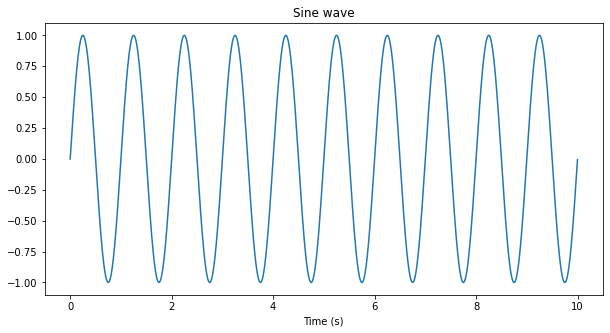

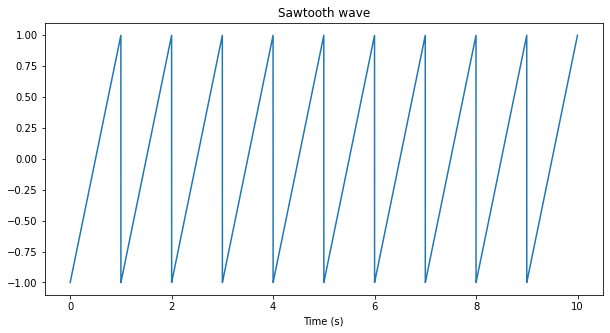

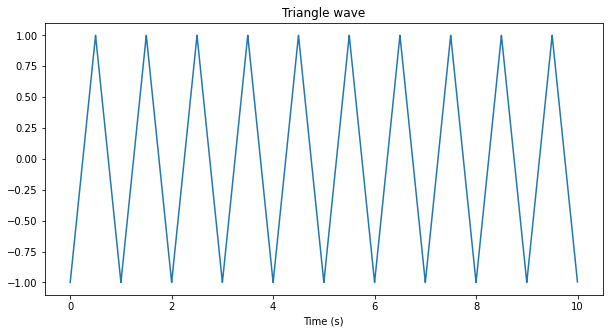

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal

t = np.arange(0, 10, 0.001)
sine_wave = np.sin(2*np.pi*t)
sawtooth_wave = signal.sawtooth(2*np.pi*t)
triangle_wave = signal.sawtooth(2*np.pi*t, 0.5)

plt.figure(figsize=(10, 5))
plt.plot(t, sine_wave)
plt.title('Sine wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, sawtooth_wave)
plt.title('Sawtooth wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, triangle_wave)
plt.title('Triangle wave')
plt.xlabel('Time (s)')
plt.show()

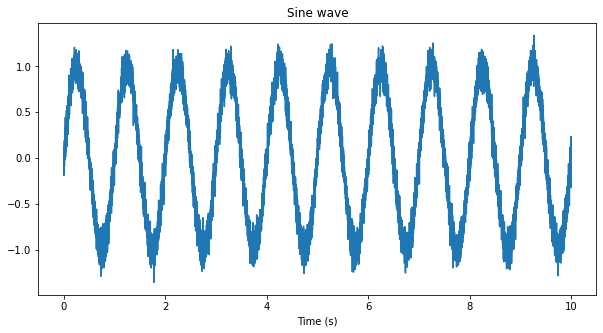

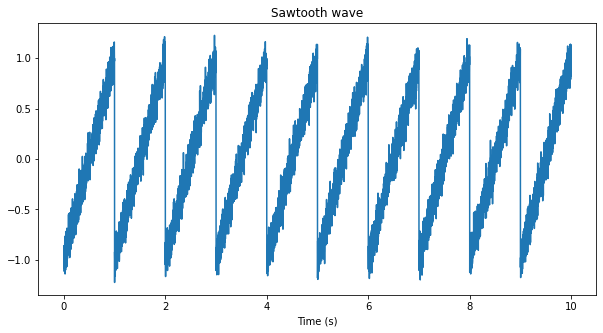

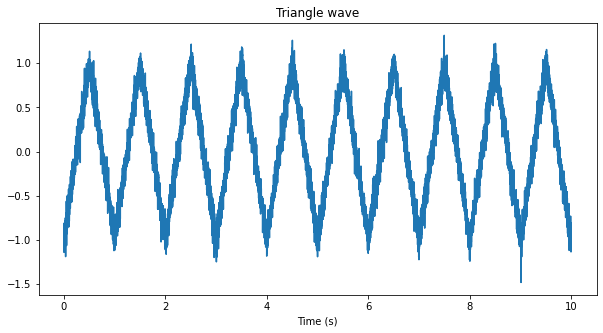

In [3]:
sine_noisy = sine_wave + np.random.normal(0,0.1,len(sine_wave))
sawtooth_noisy = sawtooth_wave + np.random.normal(0,0.1,len(sawtooth_wave))
triangle_noisy = triangle_wave + np.random.normal(0,0.1,len(triangle_wave))

plt.figure(figsize=(10, 5))
plt.plot(t, sine_noisy)
plt.title('Sine wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, sawtooth_noisy)
plt.title('Sawtooth wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, triangle_noisy)
plt.title('Triangle wave')
plt.xlabel('Time (s)')
plt.show()

In [29]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

# Prepare the input X and target Y
def get_XY(data_noisy, data, time_steps, dim):
    X = np.reshape(data_noisy, (-1, time_steps, dim))
    Y = np.reshape(data, (-1, time_steps, dim))   
    return X, Y

def print_error(trainY, testY, train_predict, test_predict, dim):    
    # Error of predictions
    train_mse = mean_squared_error(np.reshape(trainY, (-1, 1)), np.reshape(train_predict, (-1, 1)))
    test_mse = mean_squared_error(np.reshape(testY, (-1, 1)), np.reshape(test_predict, (-1, 1)))
    # Print RMSE
    print('Train MSE: %.7f MSE' % (train_mse))
    print('Test MSE: %.7f MSE' % (test_mse))   
    return train_mse

def plot_result(trainY, testY, train_predict, test_predict, Signal_name, std, Signal, LSTM_flag):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.plot(range(rows), Signal[0:len(predictions)], color='r')
    plt.axvline(x=len(trainY[0])*len(trainY), color='k')
    plt.legend(['Noisy', 'Denoised', 'Original'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel(Signal_name)
    if(LSTM_flag):
      plt.title('LSTM: Noisy, Denoised and Original Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples. '.format(Signal_name, std))
    else:
      plt.title('Simple RNN: Noisy, Denoised and Original Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples. '.format(Signal_name, std))

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), predictions)
    plt.xlabel('Observation number after given time steps')
    plt.legend(['Noisy', 'Denoised'])
    plt.ylabel(Signal_name)
    plt.axvline(x=len(trainY[0])*len(trainY), color='k')
    
    if(LSTM_flag):
      plt.title('LSTM: Denoised Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples'.format(Signal_name, std))
    else:
      plt.title('Simple RNN: Denoised Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples'.format(Signal_name, std))

def plot_result2(trainY, train_predict, Signal_name, std, Signal, LSTM_flag, time_steps):

    figure, axes = plt.subplots(1) 
    axes.plot(trainY[0, :, 0], trainY[0, :, 1]) 
    axes.plot(train_predict[:time_steps, 0], train_predict[:time_steps, 1]) 
    axes.plot(Signal[:len(trainY[0, :, 0]), 0], Signal[:len(trainY[0, :, 0]), 1], color = 'r')
    plt.legend(['Noisy', 'Denoised', 'Original']) 
    axes.set_aspect(1) 
    if(LSTM_flag):
      plt.title('LSTM: Noisy, Denoised and Original Values for {}, standard deviation = {}.'.format(Signal_name, std))
    else:
      plt.title('Simple RNN: Noisy, Denoised and Original Values for {}, standard deviation = {}.'.format(Signal_name, std))
    plt.show()


def signalPower(x):
    return np.average(np.abs(x)**2)
    
def SNRsystem(inputSig, outputSig):
    noise = outputSig-inputSig
    
    powS = signalPower(outputSig)
    powN = signalPower(noise)
    return 10*np.log10((powS-powN)/powN)

def LossAccPlot(history, dim):
  plt.figure()

  if(dim == 1):
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
  else:
    plt.plot(history.history['out1_mean_squared_error'])
    plt.plot(history.history['out2_mean_squared_error'])
    plt.plot(history.history['val_out1_mean_squared_error'])
    plt.plot(history.history['val_out2_mean_squared_error'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train_X', 'Train_Y', 'Validation_X', 'Validation_Y'], loc='upper right')
    plt.show()
     
def create_RNN(lr, LSTM_flag, num_units, dim, time_steps):
    model = Sequential()
    inputLayer = Input(shape=(time_steps,dim))
    if(LSTM_flag):
      x = LSTM(num_units, activation='tanh')(inputLayer)
    else:
      x = SimpleRNN(num_units, activation='tanh')(inputLayer)

    if(dim == 2):
      y1_output = Dense(units=time_steps, name='out1')(x)
      y2_output = Dense(units=time_steps, name='out2')(x)

      model = tf.keras.Model(inputLayer, outputs=[y2_output, y1_output])
    else:
      y_output = Dense(units=time_steps)(x)
      model = tf.keras.Model(inputLayer, outputs=y_output)

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics = 'mean_squared_error')
    return model

def process(Signal, std, Signal_name, verbose, LSTM_flag = 0, lr = 0.001, batch_size = 1, number_of_epochs = 10, gridflag = 0, noise_time = 0, dim = 1, time_steps = 1000):
  if(noise_time == 0):
    Signal_noisy = Signal + np.random.normal(0,std,size=Signal.shape)
  else: 
    Signal_noisy = [Signal[((i)*time_steps):((i+1)*time_steps)] + np.random.normal(i/10, std*i,size = Signal[((i)*time_steps):((i+1)*time_steps)].shape) for i in range(int(len(Signal)/time_steps))]

  train_noisy = Signal_noisy[0:int(0.7*len(Signal_noisy))]
  valid_noisy = Signal_noisy[int(0.7*len(Signal_noisy)):int(0.8*len(Signal_noisy))]
  test_noisy = Signal_noisy[int(0.8*len(Signal_noisy)):]

  train = Signal[0:int(0.7*len(Signal))]
  valid = Signal[int(0.7*len(Signal)):int(0.8*len(Signal))]
  test = Signal[int(0.8*len(Signal)):]

  x_train, y_train = get_XY(train_noisy, train, time_steps, dim)
  x_valid, y_valid = get_XY(valid_noisy, valid, time_steps, dim)
  x_test, y_test = get_XY(test_noisy, test, time_steps, dim)

  model = create_RNN(lr = lr, LSTM_flag = LSTM_flag, num_units = 100, dim = dim, time_steps = time_steps)
  if(dim == 2):
    history = model.fit(x_train, {'out1':y_train[:, :, 0], 'out2':y_train[:, :, 1]}, epochs=number_of_epochs, batch_size=batch_size, validation_data = (x_valid, {'out1':y_valid[:, :, 0], 'out2':y_valid[:, :, 1]}), verbose=verbose)
    # make predictions
    x_predict, y_predict = model.predict(x_train)
    x_pre, y_pre = model.predict(x_test)

    train_predict = np.concatenate((np.reshape(y_predict, (-1, 1)), np.reshape(x_predict, (-1, 1))), axis = 1)
    test_predict = np.concatenate((np.reshape(y_pre, (-1, 1)), np.reshape(x_pre, (-1, 1))), axis = 1)
  else:
    history = model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=batch_size, validation_data = (x_valid, y_valid), verbose=verbose)
    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)


  if(verbose):
  
    # Mean square error
    print_error(y_train, y_test, train_predict, test_predict, dim)

    if(dim == 1):
      plot_result(x_train, x_test, train_predict, test_predict, Signal_name, std, Signal, LSTM_flag)

    if(dim == 2):
      plot_result2(x_train, train_predict, Signal_name, std, Signal, LSTM_flag, time_steps)

    # Plot MSE for each epoch in training and validation
    LossAccPlot(history, dim)
    SNR_train = SNRsystem(np.reshape(y_train, (-1, 1)), np.reshape(train_predict, (-1, 1)))
    SNR_x = SNRsystem(np.reshape(y_train, (-1, 1)), np.reshape(x_train, (-1, 1)))
    print("SNR was {}, SNR for training output: {} dB".format(SNR_x, SNR_train))
    SNR_test = SNRsystem(np.reshape(y_test, (-1, 1)), np.reshape(test_predict, (-1, 1)))
    SNR_test_x = SNRsystem(np.reshape(y_test, (-1, 1)), np.reshape(x_test, (-1, 1)))
    print("SNR was {}, SNR for training output: {} dB".format(SNR_test_x, SNR_test))

  else:
    # Mean square error
    return print_error(y_train, y_test, train_predict, test_predict, dim)

Simple RNN

Epoch 1/10
7/7 [==============================] - 4s 464ms/step - loss: 0.3500 - mean_squared_error: 0.3500 - val_loss: 0.1054 - val_mean_squared_error: 0.1054
Epoch 2/10
7/7 [==============================] - 3s 442ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 3/10
7/7 [==============================] - 3s 444ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 4/10
7/7 [==============================] - 3s 455ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 5/10
7/7 [==============================] - 3s 444ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/10
7/7 [==============================] - 3s 447ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 7/10
7/7 [========================

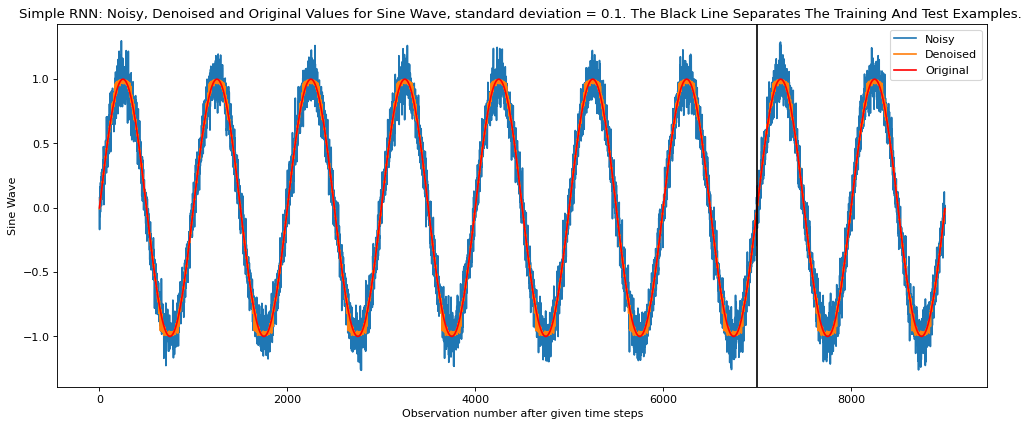

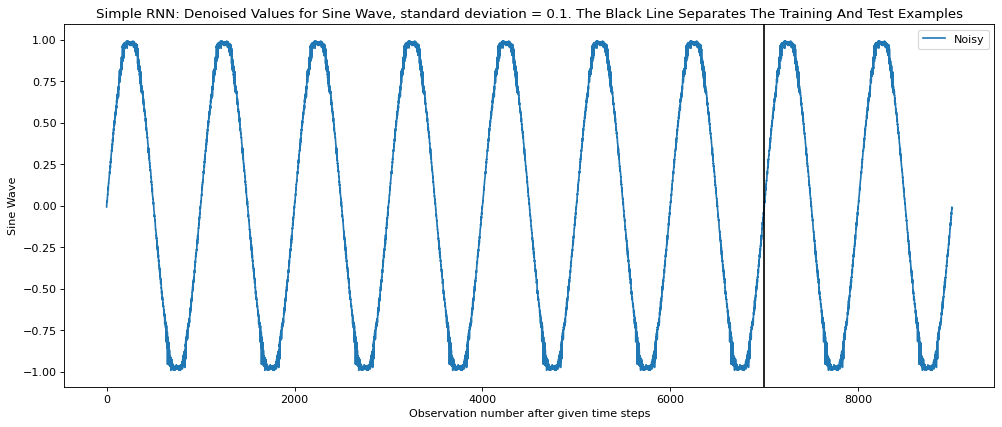

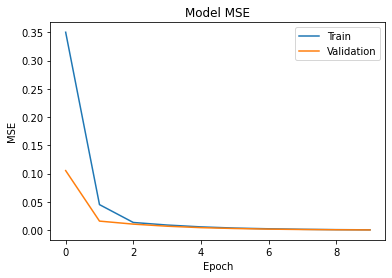

SNR was 16.98628401296987, SNR for training output: 29.976803244534853 dB
SNR was 17.02009503951691, SNR for training output: 29.981918676351164 dB


In [ ]:
# Simple RNN - Sine Wave
process(sine_wave, std = 0.1, Signal_name = 'Sine Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 1)

Epoch 1/10
7/7 [==============================] - 4s 468ms/step - loss: 0.2440 - mean_squared_error: 0.2440 - val_loss: 0.1932 - val_mean_squared_error: 0.1932
Epoch 2/10
7/7 [==============================] - 3s 451ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 3/10
7/7 [==============================] - 3s 444ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 4/10
7/7 [==============================] - 3s 438ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/10
7/7 [==============================] - 3s 459ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/10
7/7 [==============================] - 3s 443ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/10
7/7 [========================

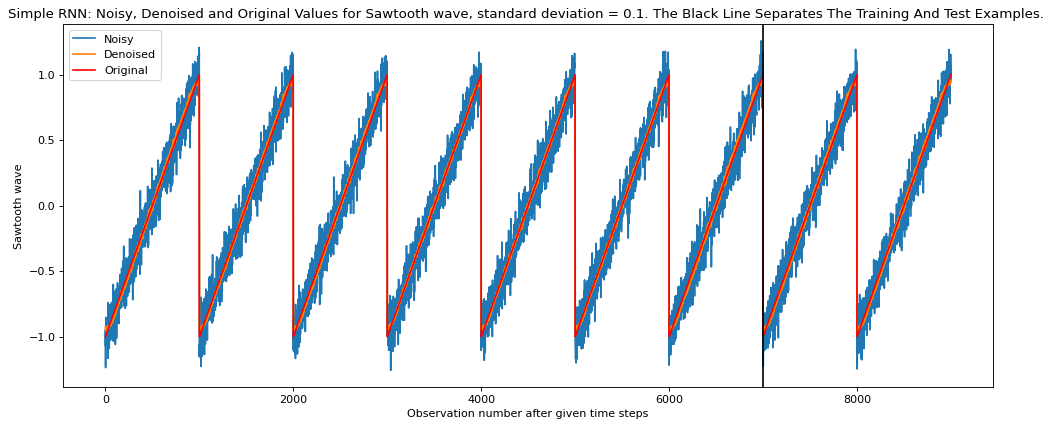

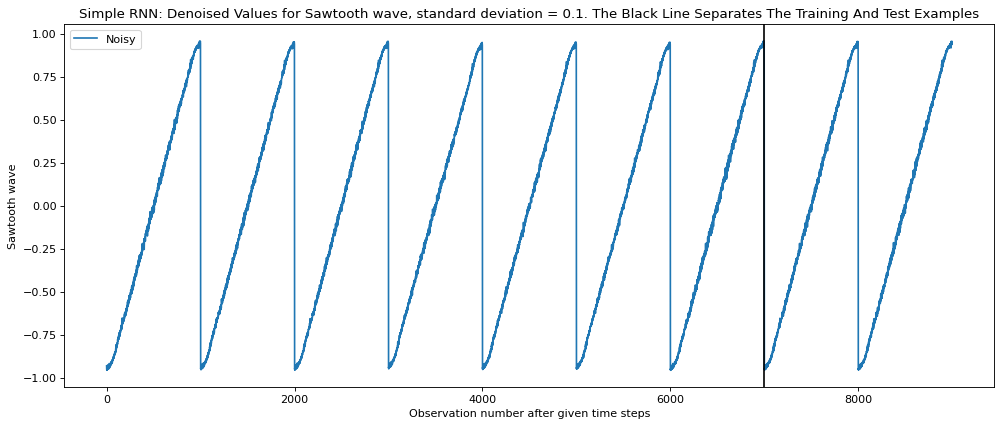

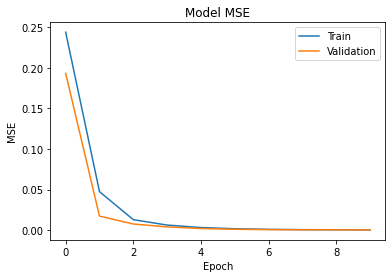

SNR was 15.1689102974189, SNR for training output: 29.548782714978344 dB
SNR was 15.327932973920875, SNR for training output: 28.791861594937608 dB


In [ ]:
# Simple RNN - Sawtooth
process(sawtooth_wave, std = 0.1, Signal_name = 'Sawtooth wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 1)

Epoch 1/10
7/7 [==============================] - 4s 450ms/step - loss: 0.2347 - mean_squared_error: 0.2347 - val_loss: 0.0752 - val_mean_squared_error: 0.0752
Epoch 2/10
7/7 [==============================] - 3s 421ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 3/10
7/7 [==============================] - 3s 423ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 4/10
7/7 [==============================] - 3s 431ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/10
7/7 [==============================] - 3s 433ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 9.6628e-04 - val_mean_squared_error: 9.6628e-04
Epoch 7/10
7/7 [================

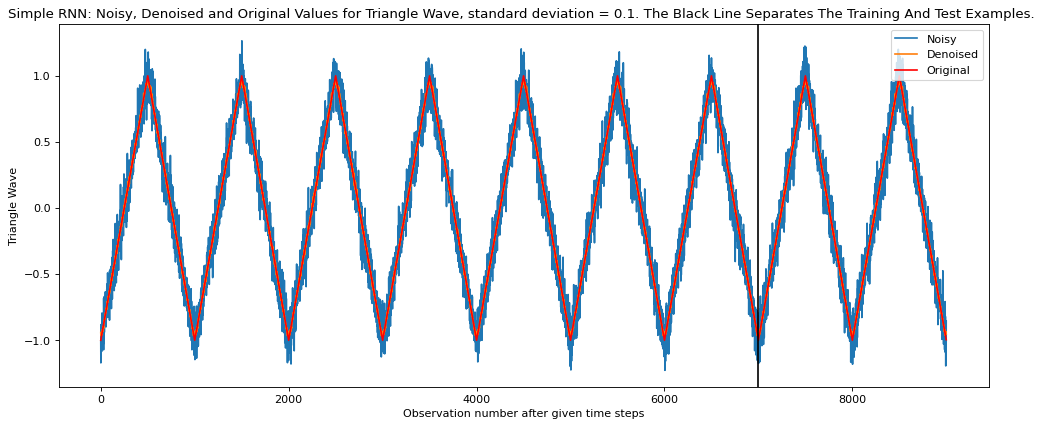

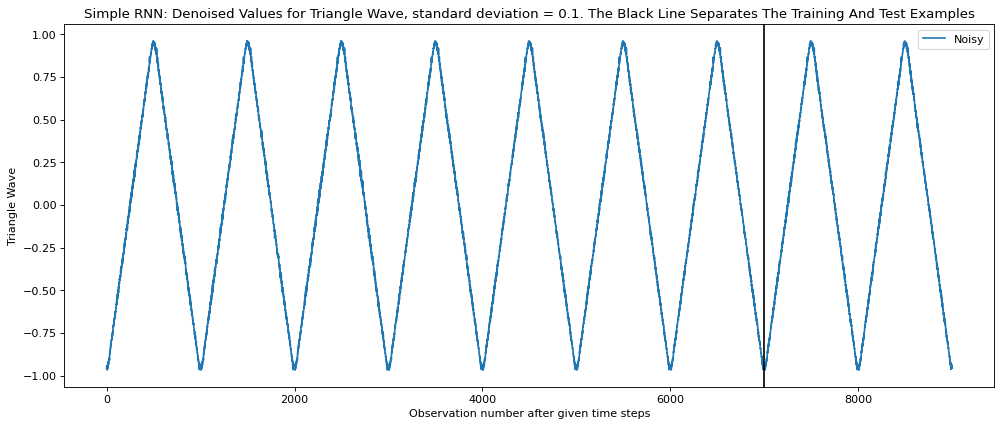

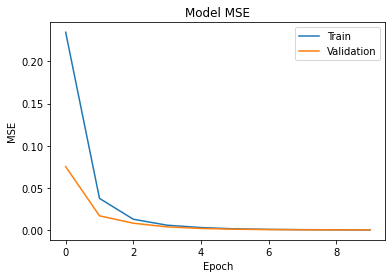

SNR was 15.298467917442713, SNR for training output: 33.95836242086269 dB
SNR was 14.99693417147956, SNR for training output: 34.05584428802144 dB


In [ ]:
# Simple RNN - Triangle
process(triangle_wave, std = 0.1, Signal_name = 'Triangle Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 1)

LSTM

Epoch 1/10
7/7 [==============================] - 4s 118ms/step - loss: 0.4852 - mean_squared_error: 0.4852 - val_loss: 0.3409 - val_mean_squared_error: 0.3409
Epoch 2/10
7/7 [==============================] - 0s 54ms/step - loss: 0.1428 - mean_squared_error: 0.1428 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 3/10
7/7 [==============================] - 0s 50ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 4/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 5/10
7/7 [==============================] - 0s 49ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 6/10
7/7 [==============================] - 0s 50ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 7/10
7/7 [=============================

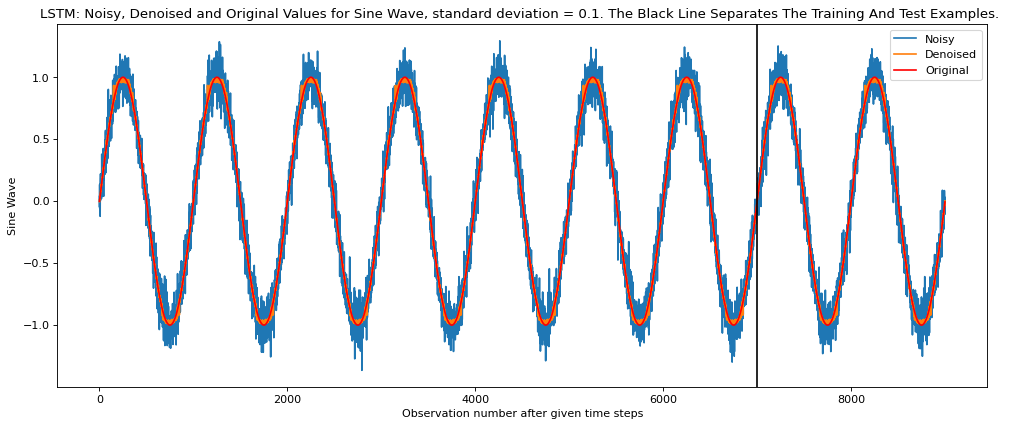

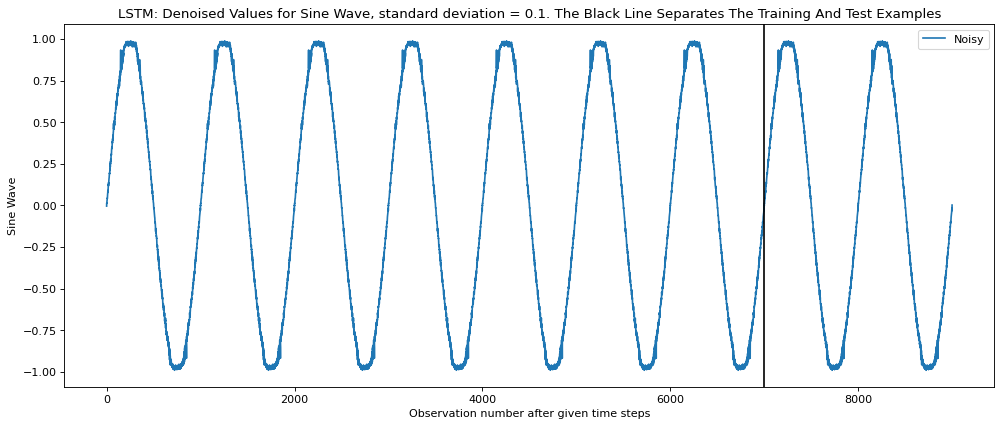

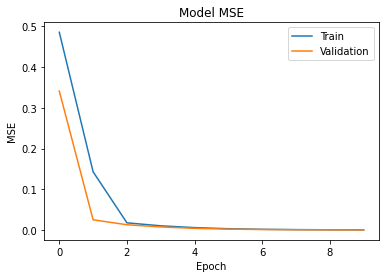

SNR was 16.966842022833973, SNR for training output: 32.319484862154134 dB
SNR was 17.210902118176232, SNR for training output: 32.32138160898437 dB


In [ ]:
# LSTM - Sine Wave
process(sine_wave, std = 0.1, Signal_name = 'Sine Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0, noise_time = 0, dim = 1)

Epoch 1/10
7/7 [==============================] - 2s 117ms/step - loss: 0.2753 - mean_squared_error: 0.2753 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 2/10
7/7 [==============================] - 0s 51ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.5958 - val_mean_squared_error: 0.5958
Epoch 3/10
7/7 [==============================] - 0s 50ms/step - loss: 0.0985 - mean_squared_error: 0.0985 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/10
7/7 [==============================] - 0s 49ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 5/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/10
7/7 [==============================] - 0s 49ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 7/10
7/7 [=============================

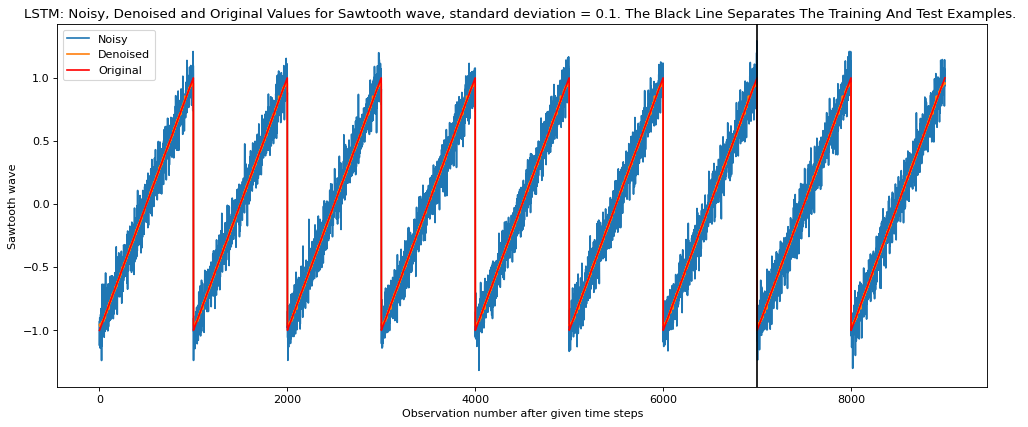

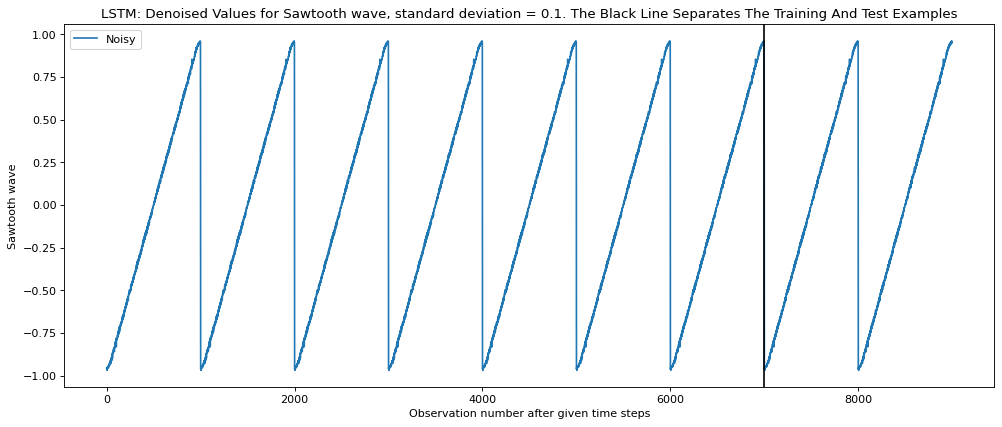

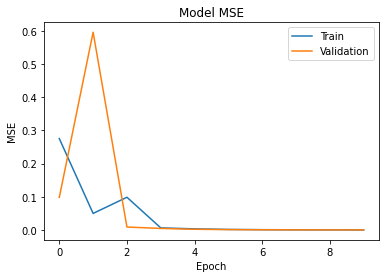

SNR was 15.142101830001312, SNR for training output: 35.41424437280484 dB
SNR was 15.029450940302901, SNR for training output: 35.410034970706754 dB


In [ ]:
# LSTM - Sawtooth
process(sawtooth_wave, std = 0.1, Signal_name = 'Sawtooth wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0, noise_time = 0, dim = 1)

Epoch 1/10
7/7 [==============================] - 2s 123ms/step - loss: 0.2727 - mean_squared_error: 0.2727 - val_loss: 0.0973 - val_mean_squared_error: 0.0973
Epoch 2/10
7/7 [==============================] - 0s 53ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 3/10
7/7 [==============================] - 0s 49ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 4/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.8973e-04 - val_mean_squared_error: 7.8973e-04
Epoch 7/10
7/7 [=====================

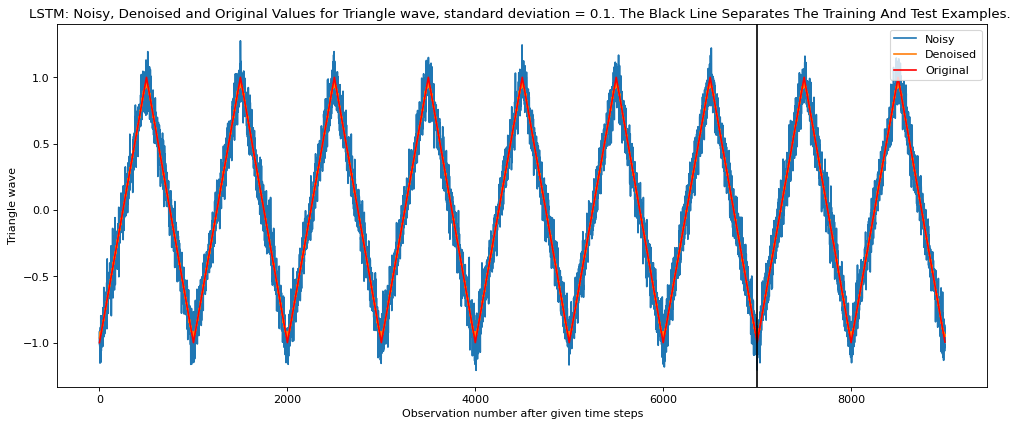

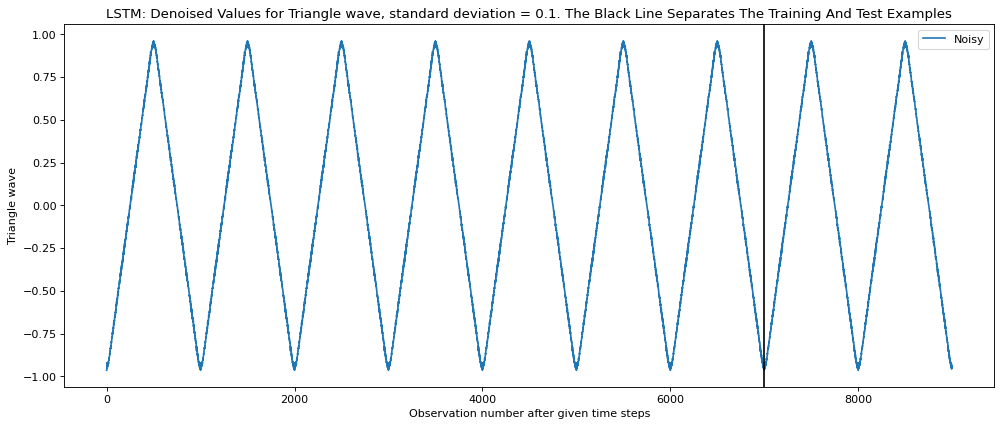

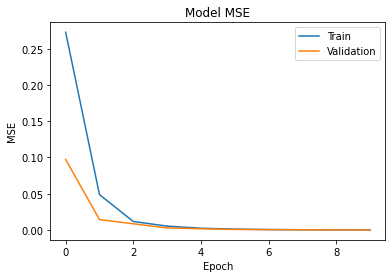

SNR was 15.319150433656139, SNR for training output: 35.07895848288263 dB
SNR was 15.372866070926312, SNR for training output: 35.071960298723845 dB


In [ ]:
# LSTM - Triangle
process(triangle_wave, std = 0.1, Signal_name = 'Triangle wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0, noise_time = 0, dim = 1)

Change Learning rate, batch size and number of epochs

Train MSE: 0.0280432 MSE
Test MSE: 0.0280437 MSE
Train MSE: 0.0003951 MSE
Test MSE: 0.0003994 MSE
Train MSE: 0.0665553 MSE
Test MSE: 0.0665450 MSE


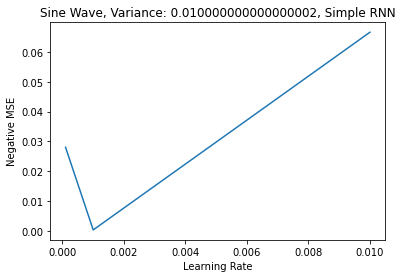

Train MSE: 0.0044336 MSE
Test MSE: 0.0044339 MSE
Train MSE: 0.0004007 MSE
Test MSE: 0.0003983 MSE
Train MSE: 0.0001217 MSE
Test MSE: 0.0001257 MSE


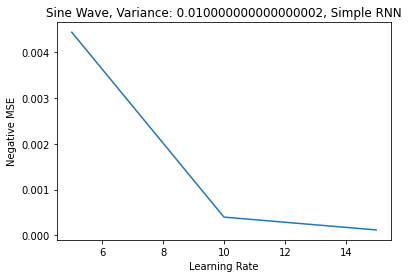

Train MSE: 0.0005718 MSE
Test MSE: 0.0005896 MSE
Train MSE: 0.0059987 MSE
Test MSE: 0.0060204 MSE
Train MSE: 0.0137280 MSE
Test MSE: 0.0137147 MSE
Train MSE: 0.2937516 MSE
Test MSE: 0.2998987 MSE


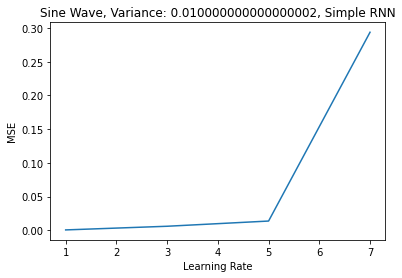

Train MSE: 0.0222538 MSE
Test MSE: 0.0222534 MSE
Train MSE: 0.0003844 MSE
Test MSE: 0.0003845 MSE
Train MSE: 1.3356079 MSE
Test MSE: 1.3356080 MSE


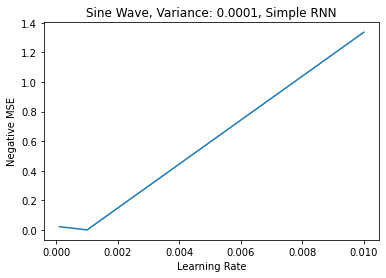

Train MSE: 0.0057108 MSE
Test MSE: 0.0057100 MSE
Train MSE: 0.0005618 MSE
Test MSE: 0.0005617 MSE
Train MSE: 0.0000825 MSE
Test MSE: 0.0000825 MSE


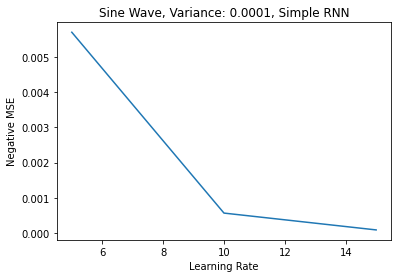

Train MSE: 0.0012564 MSE
Test MSE: 0.0012564 MSE
Train MSE: 0.0059849 MSE
Test MSE: 0.0059832 MSE
Train MSE: 0.0133444 MSE
Test MSE: 0.0133445 MSE
Train MSE: 0.0351288 MSE
Test MSE: 0.0351258 MSE


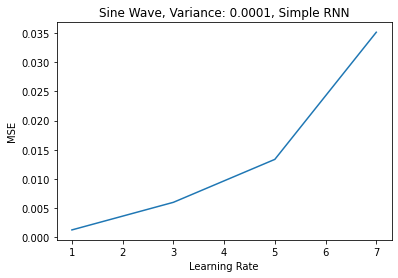

Train MSE: 0.0288730 MSE
Test MSE: 0.0288729 MSE
Train MSE: 0.0006277 MSE
Test MSE: 0.0006277 MSE
Train MSE: 1.4581785 MSE
Test MSE: 1.4581789 MSE


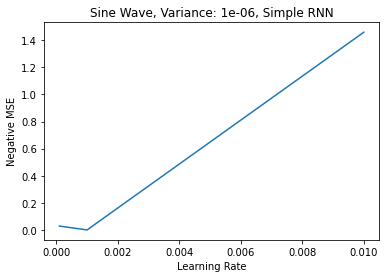

Train MSE: 0.0041049 MSE
Test MSE: 0.0041049 MSE
Train MSE: 0.0006457 MSE
Test MSE: 0.0006457 MSE
Train MSE: 0.0001433 MSE
Test MSE: 0.0001433 MSE


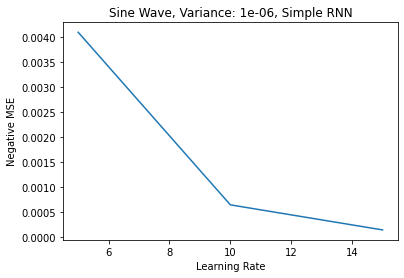

Train MSE: 0.0005388 MSE
Test MSE: 0.0005388 MSE
Train MSE: 0.0066494 MSE
Test MSE: 0.0066493 MSE
Train MSE: 0.0134039 MSE
Test MSE: 0.0134039 MSE
Train MSE: 0.0493380 MSE
Test MSE: 0.0493380 MSE


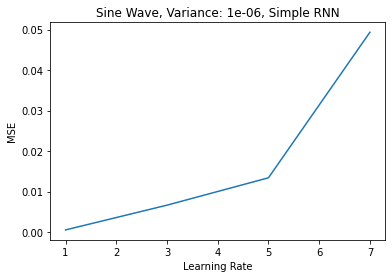

In [ ]:
for std in [0.1, 0.01, 0.001]:

  MSE_lr = []
  lr_list = [0.0001, 0.001, 0.01]
  for lr in lr_list:
    MSE_lr.append(process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 1, lr = lr))

  plt.figure()
  plt.plot(lr_list, MSE_lr)
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_epoch = []
  epoch_list = [5, 10, 15]
  for number_of_epochs in epoch_list:
    MSE_epoch.append(process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 1, number_of_epochs = number_of_epochs))

  plt.figure()
  plt.plot(epoch_list, MSE_epoch)
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_batch = []
  batch_list = [1, 3, 5, 7]
  for batch_size in batch_list:
    MSE_batch.append(process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 1, batch_size = batch_size))

  plt.figure()
  plt.plot(batch_list, MSE_batch)
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('MSE')
  plt.show()


Noise Change in time

Train MSE: 0.1822380 MSE
Test MSE: 0.1815175 MSE
Train MSE: 0.8802137 MSE
Test MSE: 0.7321245 MSE
Train MSE: 0.0810292 MSE
Test MSE: 0.0677671 MSE


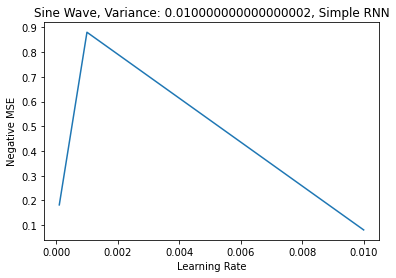

Train MSE: 0.1015734 MSE
Test MSE: 0.0514691 MSE
Train MSE: 0.0004186 MSE
Test MSE: 0.0009246 MSE
Train MSE: 0.0002689 MSE
Test MSE: 0.0010016 MSE


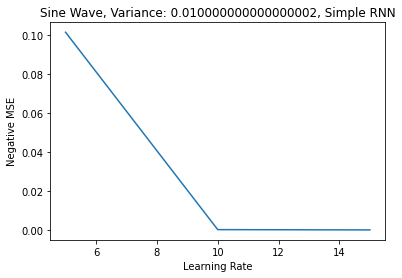

Train MSE: 0.0008606 MSE
Test MSE: 0.0012593 MSE
Train MSE: 0.1506605 MSE
Test MSE: 0.0551354 MSE
Train MSE: 0.2260640 MSE
Test MSE: 0.1654847 MSE
Train MSE: 0.3953410 MSE
Test MSE: 0.2353929 MSE


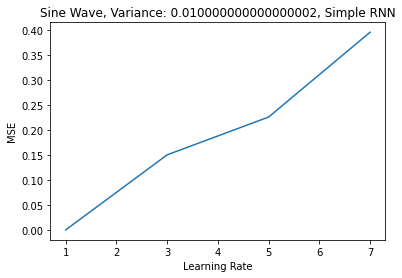

Train MSE: 0.1094642 MSE
Test MSE: 0.1098000 MSE
Train MSE: 0.0071172 MSE
Test MSE: 0.0124782 MSE
Train MSE: 1.1733297 MSE
Test MSE: 2.3644364 MSE


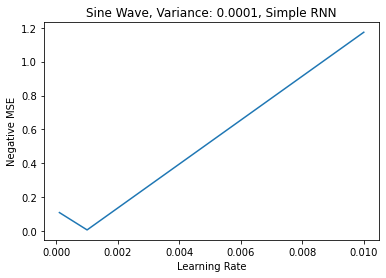

Train MSE: 0.1482160 MSE
Test MSE: 0.0214145 MSE
Train MSE: 0.6426345 MSE
Test MSE: 0.7295278 MSE
Train MSE: 0.0381241 MSE
Test MSE: 0.0189791 MSE


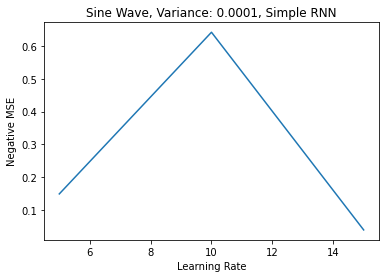

Train MSE: 0.1031478 MSE
Test MSE: 0.0305351 MSE
Train MSE: 0.0101405 MSE
Test MSE: 0.0114672 MSE
Train MSE: 0.0215915 MSE
Test MSE: 0.0193179 MSE
Train MSE: 0.0437524 MSE
Test MSE: 0.0440345 MSE


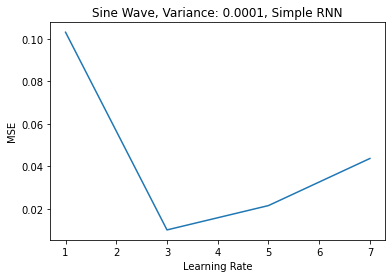

Train MSE: 0.2832697 MSE
Test MSE: 0.3215262 MSE
Train MSE: 0.2263994 MSE
Test MSE: 0.0765600 MSE
Train MSE: 0.1090217 MSE
Test MSE: 0.1090473 MSE


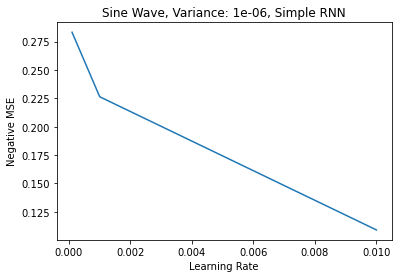

Train MSE: 0.4428617 MSE
Test MSE: 0.3157927 MSE
Train MSE: 0.0052600 MSE
Test MSE: 0.0059973 MSE
Train MSE: 0.0012733 MSE
Test MSE: 0.0016352 MSE


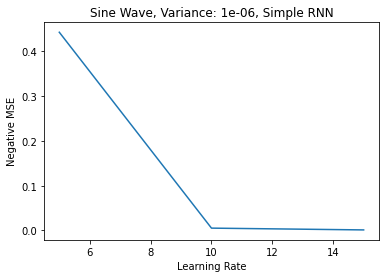

Train MSE: 0.5751960 MSE
Test MSE: 0.0516349 MSE
Train MSE: 0.1816733 MSE
Test MSE: 0.1381895 MSE
Train MSE: 0.2711952 MSE
Test MSE: 0.1411741 MSE
Train MSE: 0.3263015 MSE
Test MSE: 0.1966912 MSE


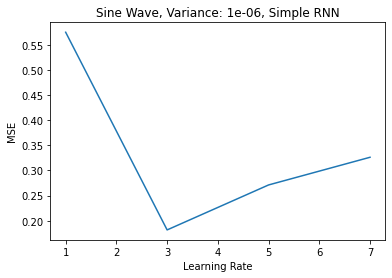

In [ ]:
for std in [0.1, 0.01, 0.001]:

  MSE_lr = []
  lr_list = [0.0001, 0.001, 0.01]
  for lr in lr_list:
    MSE_lr.append(process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 1, dim = 1, lr = lr))

  plt.figure()
  plt.plot(lr_list, MSE_lr)
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_epoch = []
  epoch_list = [5, 10, 15]
  for number_of_epochs in epoch_list:
    MSE_epoch.append(process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 1, dim = 1, number_of_epochs = number_of_epochs))

  plt.figure()
  plt.plot(epoch_list, MSE_epoch)
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_batch = []
  batch_list = [1, 3, 5, 7]
  for batch_size in batch_list:
    MSE_batch.append(process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 1, dim = 1, batch_size = batch_size))

  plt.figure()
  plt.plot(batch_list, MSE_batch)
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('MSE')
  plt.show()


Multivariate Time Series Forecasting

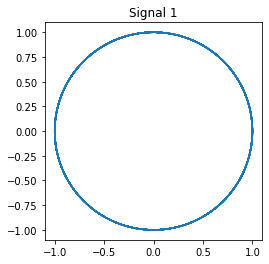

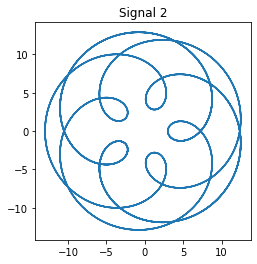

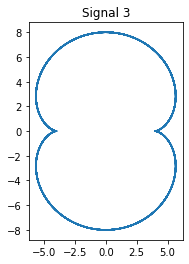

In [6]:
angle = np.linspace(0, 10*2*np.pi, 10000) 
 
x_circle = np.cos(angle) 
y_circle = np.sin(angle) 
 
x_epidro = 8*np.cos(angle) - 5*np.cos( (8/3)*angle)
y_epidro = 8*np.sin(angle) - 5*np.sin( (8/3)*angle)
 
x_neph = 2*(np.cos(3*angle) - 3*np.cos(angle))
y_neph = 2*(np.sin(3*angle) - 3*np.sin(angle))


figure, axes = plt.subplots(1) 
axes.plot(x_circle, y_circle) 
axes.set_aspect(1) 
plt.title('Signal 1') 
plt.show()

figure, axes = plt.subplots(1) 
axes.plot(x_epidro, y_epidro) 
axes.set_aspect(1) 
plt.title('Signal 2') 
plt.show()

figure, axes = plt.subplots(1) 
axes.plot(x_neph, y_neph) 
axes.set_aspect(1) 
plt.title('Signal 3') 
plt.show()

Simple RNN

Epoch 1/10
7/7 [==============================] - 4s 458ms/step - loss: 0.7554 - out2_loss: 0.3803 - out1_loss: 0.3750 - out2_mean_squared_error: 0.3803 - out1_mean_squared_error: 0.3750 - val_loss: 0.2882 - val_out2_loss: 0.1461 - val_out1_loss: 0.1421 - val_out2_mean_squared_error: 0.1461 - val_out1_mean_squared_error: 0.1421
Epoch 2/10
7/7 [==============================] - 3s 422ms/step - loss: 0.1283 - out2_loss: 0.0659 - out1_loss: 0.0624 - out2_mean_squared_error: 0.0659 - out1_mean_squared_error: 0.0624 - val_loss: 0.0424 - val_out2_loss: 0.0221 - val_out1_loss: 0.0203 - val_out2_mean_squared_error: 0.0221 - val_out1_mean_squared_error: 0.0203
Epoch 3/10
7/7 [==============================] - 3s 436ms/step - loss: 0.0355 - out2_loss: 0.0178 - out1_loss: 0.0176 - out2_mean_squared_error: 0.0178 - out1_mean_squared_error: 0.0176 - val_loss: 0.0269 - val_out2_loss: 0.0139 - val_out1_loss: 0.0130 - val_out2_mean_squared_error: 0.0139 - val_out1_mean_squared_error: 0.0130
Epoch 4/10

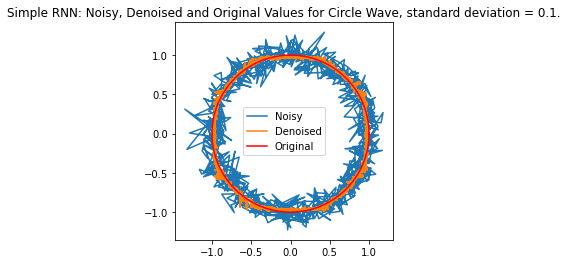

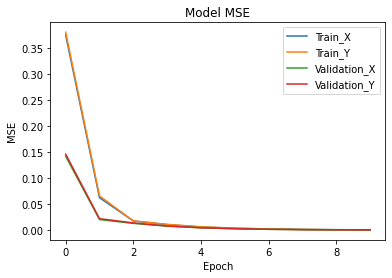

SNR was 16.914566688707335, SNR for training output: 30.62968576504257 dB
SNR was 17.065576929525758, SNR for training output: 30.533579907835037 dB


In [ ]:
# Simple RNN - Circle Wave
Signal_1 = np.concatenate((np.reshape(x_circle, (-1, 1)), np.reshape(y_circle, (-1, 1))), axis = 1)
process(Signal_1, std = 0.1, Signal_name = 'Circle Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 2)

Epoch 1/20
7/7 [==============================] - 2s 191ms/step - loss: 79.1162 - out2_loss: 39.3951 - out1_loss: 39.7211 - out2_mean_squared_error: 39.3951 - out1_mean_squared_error: 39.7211 - val_loss: 22.8159 - val_out2_loss: 11.0705 - val_out1_loss: 11.7454 - val_out2_mean_squared_error: 11.0705 - val_out1_mean_squared_error: 11.7454
Epoch 2/20
7/7 [==============================] - 1s 153ms/step - loss: 28.3888 - out2_loss: 14.1319 - out1_loss: 14.2570 - out2_mean_squared_error: 14.1319 - out1_mean_squared_error: 14.2570 - val_loss: 25.0352 - val_out2_loss: 12.9601 - val_out1_loss: 12.0751 - val_out2_mean_squared_error: 12.9601 - val_out1_mean_squared_error: 12.0751
Epoch 3/20
7/7 [==============================] - 1s 152ms/step - loss: 25.1208 - out2_loss: 12.7229 - out1_loss: 12.3979 - out2_mean_squared_error: 12.7229 - out1_mean_squared_error: 12.3979 - val_loss: 33.5076 - val_out2_loss: 17.8506 - val_out1_loss: 15.6570 - val_out2_mean_squared_error: 17.8506 - val_out1_mean_squ

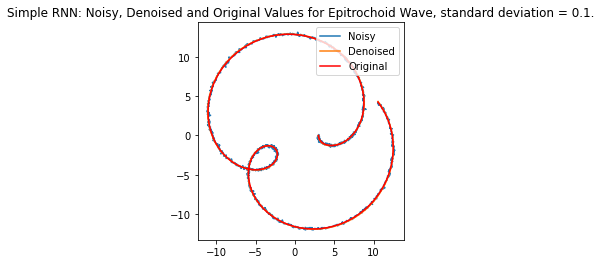

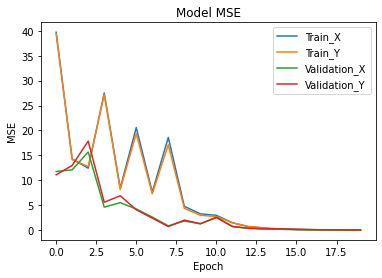

SNR was 36.530675733579, SNR for training output: 43.862618107553686 dB
SNR was 36.87112107247734, SNR for training output: 40.463963948896634 dB


In [51]:
# Simple RNN - Epitrochoid Wave
Signal_2 = np.concatenate((np.reshape(x_epidro, (-1, 1)), np.reshape(y_epidro, (-1, 1))), axis = 1)
process(Signal_2, std = 0.1, Signal_name = 'Epitrochoid Wave', lr = 0.01, batch_size = 1, number_of_epochs = 20, verbose = True, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 2)

Epoch 1/10
7/7 [==============================] - 2s 188ms/step - loss: 15.4919 - out2_loss: 8.0744 - out1_loss: 7.4175 - out2_mean_squared_error: 8.0744 - out1_mean_squared_error: 7.4175 - val_loss: 4.0346 - val_out2_loss: 1.4951 - val_out1_loss: 2.5395 - val_out2_mean_squared_error: 1.4951 - val_out1_mean_squared_error: 2.5395
Epoch 2/10
7/7 [==============================] - 1s 150ms/step - loss: 2.2657 - out2_loss: 1.2397 - out1_loss: 1.0260 - out2_mean_squared_error: 1.2397 - out1_mean_squared_error: 1.0260 - val_loss: 1.0093 - val_out2_loss: 0.3427 - val_out1_loss: 0.6667 - val_out2_mean_squared_error: 0.3427 - val_out1_mean_squared_error: 0.6667
Epoch 3/10
7/7 [==============================] - 1s 149ms/step - loss: 0.7630 - out2_loss: 0.3710 - out1_loss: 0.3920 - out2_mean_squared_error: 0.3710 - out1_mean_squared_error: 0.3920 - val_loss: 0.5740 - val_out2_loss: 0.3042 - val_out1_loss: 0.2698 - val_out2_mean_squared_error: 0.3042 - val_out1_mean_squared_error: 0.2698
Epoch 4/1

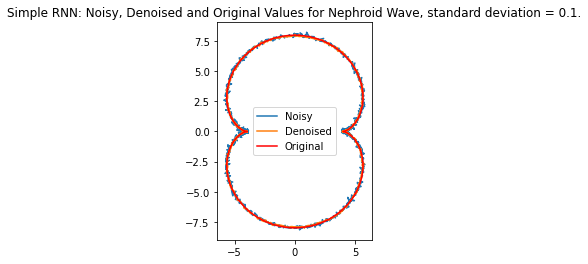

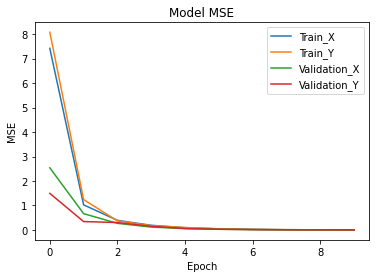

SNR was 33.07863548291227, SNR for training output: 39.77390230640736 dB
SNR was 32.887066040007205, SNR for training output: 39.95972542194108 dB


In [52]:
# Simple RNN - Epitrochoid Wave
Signal_3 = np.concatenate((np.reshape(x_neph, (-1, 1)), np.reshape(y_neph, (-1, 1))), axis = 1)
process(Signal_3, std = 0.1, Signal_name = 'Nephroid Wave', lr = 0.01, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 2)

LSTM

Epoch 1/10
7/7 [==============================] - 2s 131ms/step - loss: 0.8565 - out2_loss: 0.4294 - out1_loss: 0.4271 - out2_mean_squared_error: 0.4294 - out1_mean_squared_error: 0.4271 - val_loss: 0.3300 - val_out2_loss: 0.1664 - val_out1_loss: 0.1636 - val_out2_mean_squared_error: 0.1664 - val_out1_mean_squared_error: 0.1636
Epoch 2/10
7/7 [==============================] - 0s 53ms/step - loss: 0.1458 - out2_loss: 0.0727 - out1_loss: 0.0731 - out2_mean_squared_error: 0.0727 - out1_mean_squared_error: 0.0731 - val_loss: 0.0449 - val_out2_loss: 0.0222 - val_out1_loss: 0.0228 - val_out2_mean_squared_error: 0.0222 - val_out1_mean_squared_error: 0.0228
Epoch 3/10
7/7 [==============================] - 0s 50ms/step - loss: 0.0336 - out2_loss: 0.0166 - out1_loss: 0.0169 - out2_mean_squared_error: 0.0166 - out1_mean_squared_error: 0.0169 - val_loss: 0.0247 - val_out2_loss: 0.0127 - val_out1_loss: 0.0120 - val_out2_mean_squared_error: 0.0127 - val_out1_mean_squared_error: 0.0120
Epoch 4/10
7

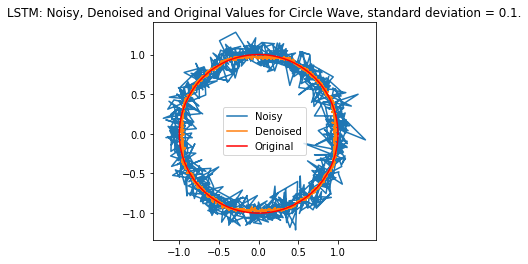

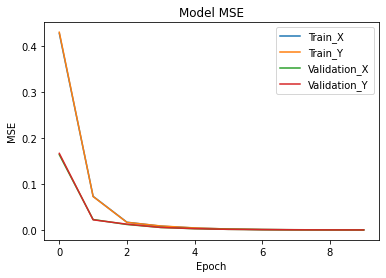

SNR was 16.955008212849222, SNR for training output: 33.41235301106754 dB
SNR was 17.04186655351675, SNR for training output: 33.35859671314331 dB


In [ ]:
# LSTM - Circle Wave
Signal_1 = np.concatenate((np.reshape(x_circle, (-1, 1)), np.reshape(y_circle, (-1, 1))), axis = 1)
process(Signal_1, std = 0.1, Signal_name = 'Circle Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0, noise_time = 0, dim = 2)

Epoch 1/30
35/35 [==============================] - 4s 52ms/step - loss: 72.5943 - out2_loss: 32.8613 - out1_loss: 39.7330 - out2_mean_squared_error: 32.8613 - out1_mean_squared_error: 39.7330 - val_loss: 38.0203 - val_out2_loss: 15.9108 - val_out1_loss: 22.1095 - val_out2_mean_squared_error: 15.9108 - val_out1_mean_squared_error: 22.1095
Epoch 2/30
35/35 [==============================] - 1s 38ms/step - loss: 47.1461 - out2_loss: 24.0763 - out1_loss: 23.0698 - out2_mean_squared_error: 24.0763 - out1_mean_squared_error: 23.0698 - val_loss: 38.4001 - val_out2_loss: 21.1569 - val_out1_loss: 17.2432 - val_out2_mean_squared_error: 21.1569 - val_out1_mean_squared_error: 17.2432
Epoch 3/30
35/35 [==============================] - 1s 39ms/step - loss: 35.5469 - out2_loss: 18.1151 - out1_loss: 17.4318 - out2_mean_squared_error: 18.1151 - out1_mean_squared_error: 17.4318 - val_loss: 19.8595 - val_out2_loss: 11.9364 - val_out1_loss: 7.9231 - val_out2_mean_squared_error: 11.9364 - val_out1_mean_s

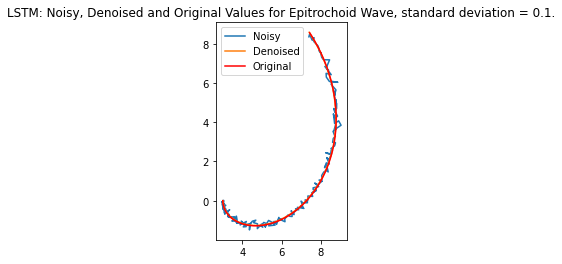

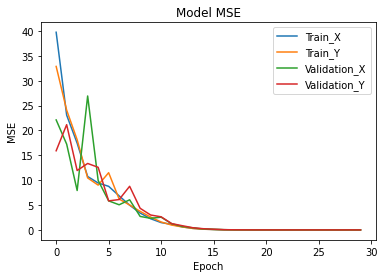

SNR was 36.523336529130894, SNR for training output: 47.93695300066119 dB
SNR was 36.73229442453335, SNR for training output: 42.44446361123855 dB


In [35]:
# LSTM - Epitrochoid Wave
Signal_2 = np.concatenate((np.reshape(x_epidro, (-1, 1)), np.reshape(y_epidro, (-1, 1))), axis = 1)
process(Signal_2, std = 0.1, Signal_name = 'Epitrochoid Wave', lr = 0.01, batch_size = 1, number_of_epochs = 30, verbose = True, LSTM_flag = 1, gridflag = 0, noise_time = 0, dim = 2, time_steps=200)

Epoch 1/10
35/35 [==============================] - 3s 54ms/step - loss: 21.5764 - out2_loss: 12.0506 - out1_loss: 9.5258 - out2_mean_squared_error: 12.0506 - out1_mean_squared_error: 9.5258 - val_loss: 11.6468 - val_out2_loss: 7.4255 - val_out1_loss: 4.2213 - val_out2_mean_squared_error: 7.4255 - val_out1_mean_squared_error: 4.2213
Epoch 2/10
35/35 [==============================] - 1s 39ms/step - loss: 7.9139 - out2_loss: 4.5510 - out1_loss: 3.3629 - out2_mean_squared_error: 4.5510 - out1_mean_squared_error: 3.3629 - val_loss: 3.4642 - val_out2_loss: 1.9372 - val_out1_loss: 1.5270 - val_out2_mean_squared_error: 1.9372 - val_out1_mean_squared_error: 1.5270
Epoch 3/10
35/35 [==============================] - 1s 38ms/step - loss: 5.3125 - out2_loss: 2.2676 - out1_loss: 3.0450 - out2_mean_squared_error: 2.2676 - out1_mean_squared_error: 3.0450 - val_loss: 2.5991 - val_out2_loss: 1.5548 - val_out1_loss: 1.0443 - val_out2_mean_squared_error: 1.5548 - val_out1_mean_squared_error: 1.0443
Epo

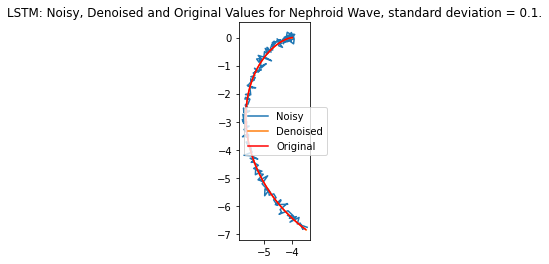

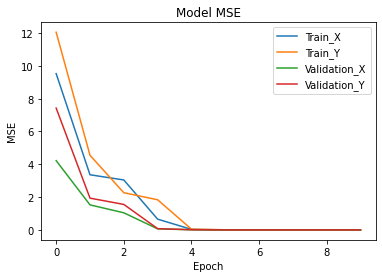

SNR was 32.975867019183234, SNR for training output: 51.39883958947151 dB
SNR was 32.99243870925982, SNR for training output: 45.81939872337504 dB


In [36]:
# LSTM - Nephroid Wave
Signal_3 = np.concatenate((np.reshape(x_neph, (-1, 1)), np.reshape(y_neph, (-1, 1))), axis = 1)
process(Signal_3, std = 0.1, Signal_name = 'Nephroid Wave', lr = 0.01, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0, noise_time = 0, dim = 2, time_steps=200)

Change Learning rate, batch size and number of epochs

Train MSE: 0.0348472 MSE
Test MSE: 0.0347919 MSE
Train MSE: 0.0004103 MSE
Test MSE: 0.0004177 MSE
Train MSE: 0.6477111 MSE
Test MSE: 0.6484366 MSE


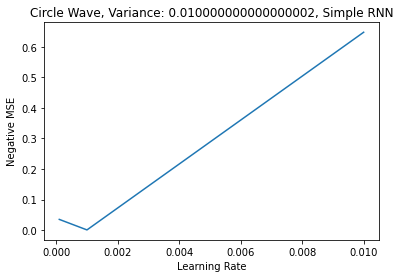

Train MSE: 0.0051690 MSE
Test MSE: 0.0051663 MSE
Train MSE: 0.0003779 MSE
Test MSE: 0.0003912 MSE
Train MSE: 0.0001087 MSE
Test MSE: 0.0001096 MSE


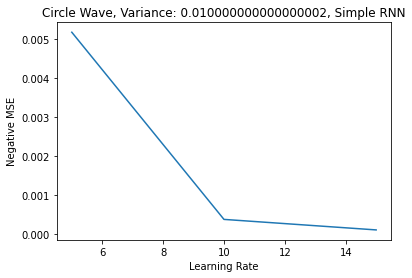

Train MSE: 0.0004146 MSE
Test MSE: 0.0004074 MSE
Train MSE: 0.0063766 MSE
Test MSE: 0.0063506 MSE
Train MSE: 0.0137010 MSE
Test MSE: 0.0137283 MSE
Train MSE: 0.0314325 MSE
Test MSE: 0.0314467 MSE


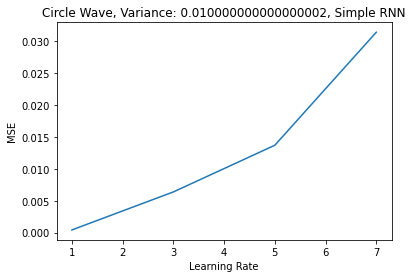

Train MSE: 0.0357115 MSE
Test MSE: 0.0356940 MSE
Train MSE: 0.0003739 MSE
Test MSE: 0.0003795 MSE
Train MSE: 0.0273230 MSE
Test MSE: 0.0273220 MSE


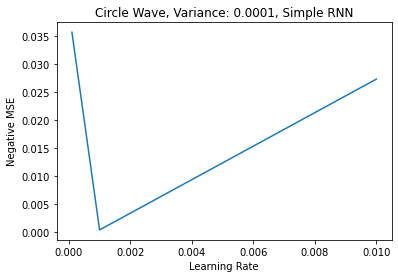

Train MSE: 0.0044826 MSE
Test MSE: 0.0044862 MSE
Train MSE: 0.0003639 MSE
Test MSE: 0.0003693 MSE
Train MSE: 0.0001004 MSE
Test MSE: 0.0001055 MSE


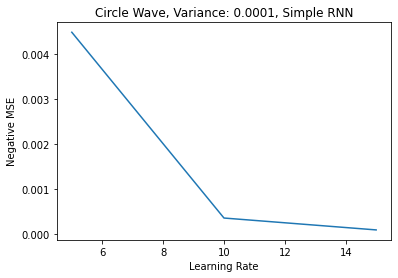

Train MSE: 0.0003784 MSE
Test MSE: 0.0003833 MSE
Train MSE: 0.0065220 MSE
Test MSE: 0.0065288 MSE
Train MSE: 0.0142835 MSE
Test MSE: 0.0142678 MSE
Train MSE: 0.1479073 MSE
Test MSE: 0.1480321 MSE


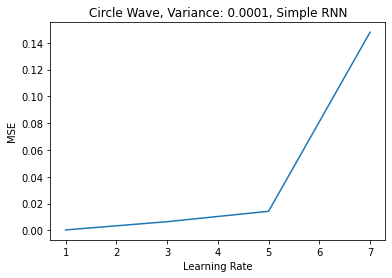

Train MSE: 0.0310170 MSE
Test MSE: 0.0309970 MSE
Train MSE: 0.0003424 MSE
Test MSE: 0.0003477 MSE
Train MSE: 0.0421300 MSE
Test MSE: 0.0421433 MSE


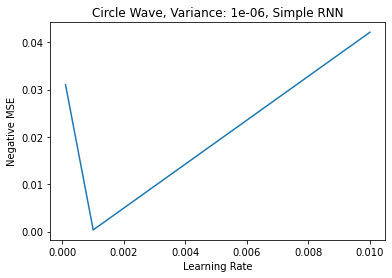

Train MSE: 0.0044902 MSE
Test MSE: 0.0044917 MSE
Train MSE: 0.0003744 MSE
Test MSE: 0.0003787 MSE
Train MSE: 0.0000911 MSE
Test MSE: 0.0000984 MSE


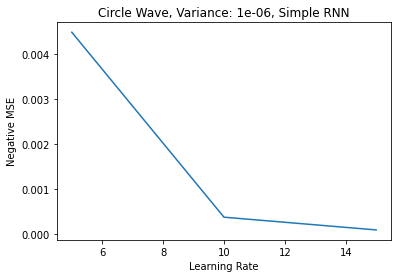

Train MSE: 0.0003602 MSE
Test MSE: 0.0003680 MSE
Train MSE: 0.0070165 MSE
Test MSE: 0.0070301 MSE
Train MSE: 0.0146802 MSE
Test MSE: 0.0146958 MSE
Train MSE: 0.0438348 MSE
Test MSE: 0.0438415 MSE


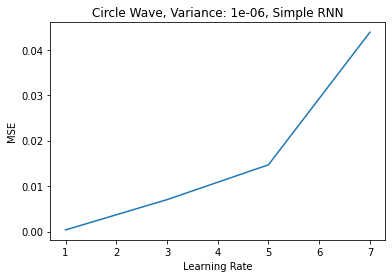

In [ ]:
for std in [0.1, 0.01, 0.001]:

  MSE_lr = []
  lr_list = [0.0001, 0.001, 0.01]
  for lr in lr_list:
    MSE_lr.append(process(Signal_1, std = std, Signal_name = 'Circle Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 2, lr = lr))

  plt.figure()
  plt.plot(lr_list, MSE_lr)
  plt.title('Circle Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_epoch = []
  epoch_list = [5, 10, 15]
  for number_of_epochs in epoch_list:
    MSE_epoch.append(process(Signal_1, std = std, Signal_name = 'Circle Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 2, number_of_epochs = number_of_epochs))

  plt.figure()
  plt.plot(epoch_list, MSE_epoch)
  plt.title('Circle Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_batch = []
  batch_list = [1, 3, 5, 7]
  for batch_size in batch_list:
    MSE_batch.append(process(Signal_1, std = std, Signal_name = 'Circle Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 0, dim = 2, batch_size = batch_size))

  plt.figure()
  plt.plot(batch_list, MSE_batch)
  plt.title('Circle Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('MSE')
  plt.show()


Noise Change in time

Train MSE: 0.0574100 MSE
Test MSE: 0.0585652 MSE
Train MSE: 0.0007202 MSE
Test MSE: 0.0018221 MSE
Train MSE: 0.0143952 MSE
Test MSE: 0.0142757 MSE


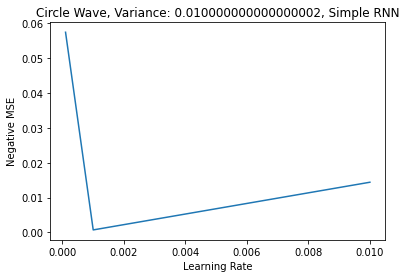

Train MSE: 0.0054994 MSE
Test MSE: 0.0059011 MSE
Train MSE: 0.0006160 MSE
Test MSE: 0.0024624 MSE
Train MSE: 0.0002215 MSE
Test MSE: 0.0017873 MSE


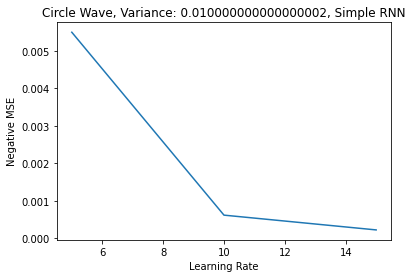

Train MSE: 0.0009020 MSE
Test MSE: 0.0064667 MSE
Train MSE: 0.0061230 MSE
Test MSE: 0.0069616 MSE
Train MSE: 0.0134074 MSE
Test MSE: 0.0135213 MSE
Train MSE: 0.0438475 MSE
Test MSE: 0.0440697 MSE


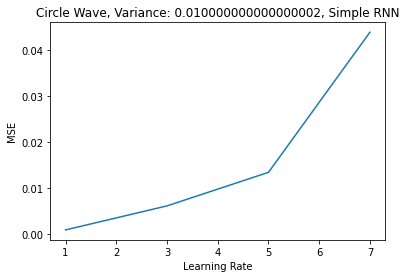

Train MSE: 0.0474949 MSE
Test MSE: 0.0473945 MSE
Train MSE: 0.0004949 MSE
Test MSE: 0.0006420 MSE
Train MSE: 0.0507205 MSE
Test MSE: 0.0507756 MSE


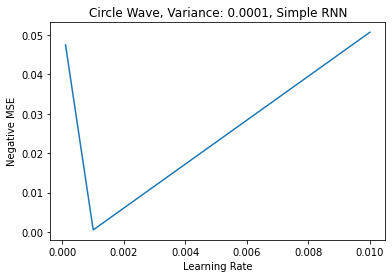

Train MSE: 0.0046988 MSE
Test MSE: 0.0051028 MSE
Train MSE: 0.0005289 MSE
Test MSE: 0.0007874 MSE
Train MSE: 0.0001556 MSE
Test MSE: 0.0003741 MSE


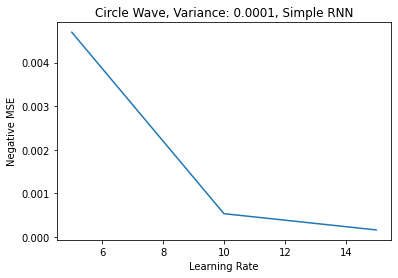

Train MSE: 0.0004482 MSE
Test MSE: 0.0007026 MSE
Train MSE: 0.0062007 MSE
Test MSE: 0.0065095 MSE
Train MSE: 0.0137936 MSE
Test MSE: 0.0140865 MSE
Train MSE: 0.0400500 MSE
Test MSE: 0.0404519 MSE


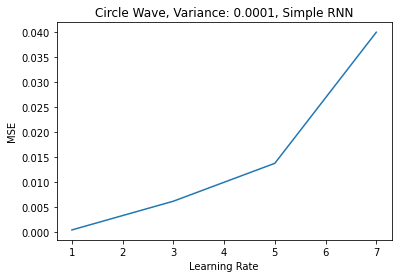

Train MSE: 0.0447672 MSE
Test MSE: 0.0443619 MSE
Train MSE: 0.0004581 MSE
Test MSE: 0.0007811 MSE
Train MSE: 0.0407628 MSE
Test MSE: 0.0407562 MSE


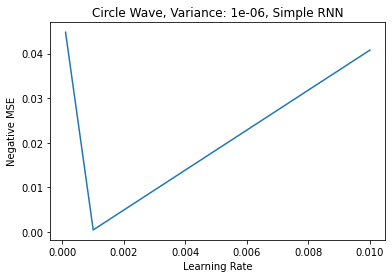

Train MSE: 0.0045031 MSE
Test MSE: 0.0046902 MSE
Train MSE: 0.0004142 MSE
Test MSE: 0.0005337 MSE
Train MSE: 0.0001229 MSE
Test MSE: 0.0002997 MSE


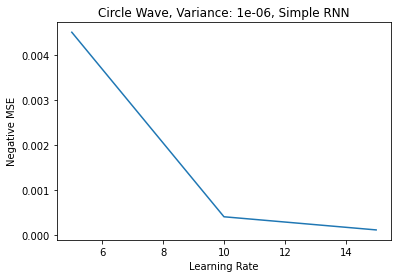

Train MSE: 0.0004148 MSE
Test MSE: 0.0006022 MSE
Train MSE: 0.0065986 MSE
Test MSE: 0.0069238 MSE
Train MSE: 0.0140517 MSE
Test MSE: 0.0143969 MSE
Train MSE: 0.0505318 MSE
Test MSE: 0.0493575 MSE


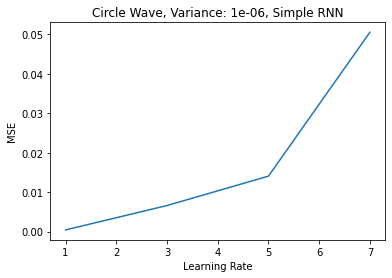

In [ ]:
for std in [0.1, 0.01, 0.001]:

  MSE_lr = []
  lr_list = [0.0001, 0.001, 0.01]
  for lr in lr_list:
    MSE_lr.append(process(Signal_1, std = std, Signal_name = 'Circle Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 1, dim = 2, lr = lr))

  plt.figure()
  plt.plot(lr_list, MSE_lr)
  plt.title('Circle Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_epoch = []
  epoch_list = [5, 10, 15]
  for number_of_epochs in epoch_list:
    MSE_epoch.append(process(Signal_1, std = std, Signal_name = 'Circle Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 1, dim = 2, number_of_epochs = number_of_epochs))

  plt.figure()
  plt.plot(epoch_list, MSE_epoch)
  plt.title('Circle Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

  MSE_batch = []
  batch_list = [1, 3, 5, 7]
  for batch_size in batch_list:
    MSE_batch.append(process(Signal_1, std = std, Signal_name = 'Circle Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 1, dim = 2, batch_size = batch_size))

  plt.figure()
  plt.plot(batch_list, MSE_batch)
  plt.title('Circle Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('MSE')
  plt.show()
